#MIT License
Copyright 2018 Ed Costantini
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

costed12@gmail.com
Dataset from https://s3-us-west-2.amazonaws.com/rm-exercise/rm_topic_modeling_data.zip

Extensively references example notebooks from: https://github.com/derekgreene/topic-model-tutorial

In [2]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "data-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 1837 X 5901 document-term matrix


In [3]:
kmin, kmax = 5, 15

In [4]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


In [5]:
raw_documents = []
with open("topic_modeling_data.json" ,"r") as fin:
    for line in fin.readlines():
        #split line based on comma
        uid,txt=line.split(",",1)
        #append text element
        txt2=txt[9:(-2)]
        text = txt2.strip()
        raw_documents.append( text )

print("Read %d raw text documents" % len(raw_documents))

Read 1837 raw text documents


In [6]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [7]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [9]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 5
ft_model = gensim.models.FastText(docgen, size=500, min_count=1, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [10]:
print( "Model has %d terms" % len(ft_model.wv.vocab) )

Model has 110133 terms


In [11]:
ft_model.save("ft-model.bin")

In [12]:
# # To re-load this model, run
# ft_model = gensim.models.Word2Vec.load("ft-model.bin")

In [13]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [14]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [15]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 3 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( ft_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=05: Coherence=0.4919
K=06: Coherence=0.5042
K=07: Coherence=0.5273
K=08: Coherence=0.5308
K=09: Coherence=0.5147
K=10: Coherence=0.5190
K=11: Coherence=0.5062
K=12: Coherence=0.5250
K=13: Coherence=0.5312
K=14: Coherence=0.5263
K=15: Coherence=0.5220


C:\Users\Eddie\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
C:\Users\Eddie\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

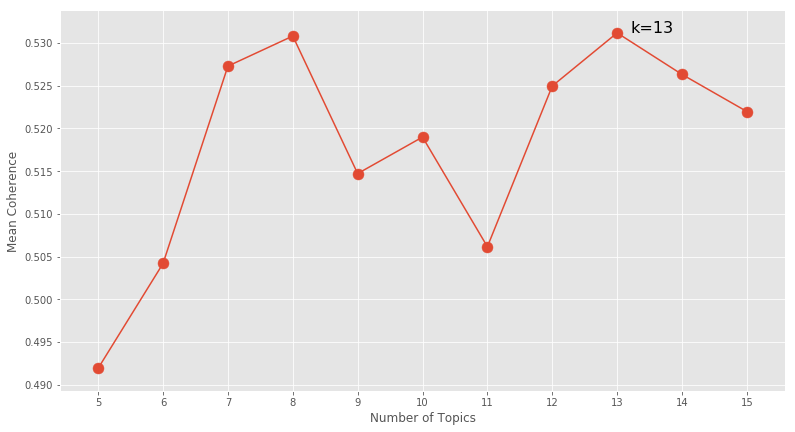

In [17]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

The plot above suggests that the most appropriate value for the number of topics is k=13.

In [18]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: deposit, bonus, players, 2nd, claimed, 3rd, spins, wagering, awarded, malta
Topic 02: download, mp3, free, songs, music, movie, song, movies, full, video
Topic 03: de, descargar, gratis, para, en, la, el, descarga, mp3, que
Topic 04: option, browser, webmail, script, click, computer, web, internet, security, tr
Topic 05: deposit, slot, machine, free, spins, casino, 1000, bonus, 120, australia
Topic 06: casino, account, players, right, reserves, bonus, mondial, andor, player, funds
Topic 07: prevent, computer, logins, disabled, call, alert, toll, immediately, pornographic, warning
Topic 08: securetrade, issued, rolla, cookie, rewards, mt, malta, missions, tournaments, 19
Topic 09: play, slots, video, live, blackjack, games, fun, table, popular, poker
Topic 10: technicians, immediate, assistance, windows, certified, system, shutdown, 18663944845, unknown, contact
Topic 11: bonus, toprated, games, 250, comes, table, amount, coupon, withdrawal, poker
Topic 12: alert, window, acti